# Histopathological image classification: Starting Kit

### Authors: 
#### Charlotte LACLAU (charlotte.laclau@telecom-paris.fr ),   Awais SANI (awais.sani@telecom-paris.fr)

## Context

For this data challenge, you will work on histopathological images. The dataset consists of microscopic images of breast tumor tissue collected from several patients. These images have the following properties: 700x460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format.  

You will be provided with two subfolders. 
- **Train** contains the set of training images (with labels)
- **Test** contains the set of images on which you will be evaluated (no available labels)

### Objective and Evaluation metrics
These images correspond to samples of breast tumors that are either benign or malignant. Among malginants, we can also distinguish between different types of tumors. For this data challenge, you will be evaluated on the prediction of the type of tumors (8 possible classes). 

The chosen metric for this evalaution is the F1-Score (weighted average) implemented in scikit-learn (`sklearn.metrics.f1_score`).

### LeaderBoard Explanation

You will be evaluated on the test set and your score will be displayed on a public learderboard available at      

datachallenge.enst.fr

To limit overfitting on the test set, the number of submissions is limited to 2 per day for each team. Every time a team submits a solution, the score is displayed and updated on the leaderboard. 

### Some imports

Here are some imports that will be useful for the data challenge
* cv2 : `!pip install opencv-python`
* scikit-image: `!pip install scikit-image`
* scikit-learn: `!pip install scikit-learn`

In [4]:
import numpy as np
import pandas as pd
import cv2
import mahotas
import os
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage import io
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [5]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

### Getting the data 

To download the data, follow this link - then unzip the file

https://partage.imt.fr/index.php/s/RQSJsEpSjkc9oTZ

### Training Data visualisation

* A first step is to create the list of all available images using the `os.listdir` function provided by `os` library (https://docs.python.org/3/library/os.html).

* Hereafter we wrote the code to get all the filenames, print the total number of files and show the first image of the list using `skimage.io` library (https://scikit-image.org/docs/dev/api/skimage.io.html)

data-challenge/Train/SOB_B_F-14-14134E-100-028.png
Number of images:  422


<function skimage.io._io.show()>

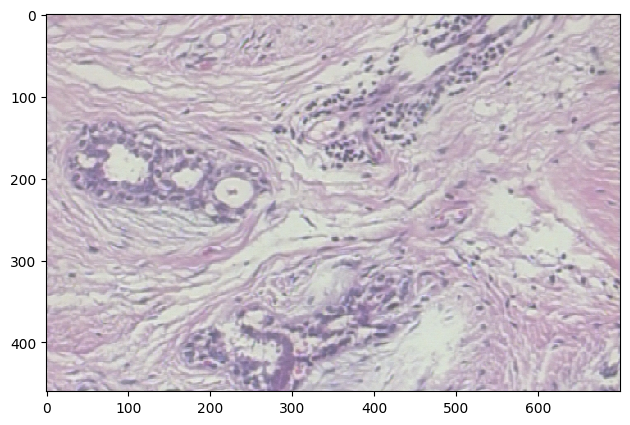

In [53]:
from skimage import io
import os

# get images list from folder using os.listdir
train_path = 'data-challenge/Train/'
test_path = 'data-challenge/Test/'

images = os.listdir(path=train_path)
print(train_path + images[0])
# Number of images
print("Number of images: ", len(images))

# Image visualisation
io.imshow(train_path + images[0])
io.show

### Dataset building

* Now we can build a pandas `DataFrame` to store the information about the images. All the informations are contained in the filename of each image. 

* For example, SOB_B_TA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB. 

* Using the function `str.split` we can create new columns in the dataframe corresponding to the class, subclass and slide from each image.

In [39]:
def parse_fn(filename):
    # <BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>-<YEAR>-<SLIDE_ID>-<MAG>-<SEQ>
    parsed = filename[:-4].replace('-', '_').split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'class', 'type', 'magnification', 'slide', 'mag', 'seq', 'filename']

df = pd.DataFrame(list(map(parse_fn, images)), columns=columns)
label_types = df['type'].unique()
print(label_types)
print(df.head())

['F' 'LC' 'A' 'PC' 'MC' 'DC' 'TA' 'PT']
  procedure class type magnification    slide  mag  seq                        filename
0       SOB     B    F            14   14134E  100  028   SOB_B_F-14-14134E-100-028.png
1       SOB     M   LC            14    16196  100  013   SOB_M_LC-14-16196-100-013.png
2       SOB     B    A            14  29960CD  100  012  SOB_B_A-14-29960CD-100-012.png
3       SOB     B    A            14  22549AB  100  013  SOB_B_A-14-22549AB-100-013.png
4       SOB     M   PC            14    15704  100  012   SOB_M_PC-14-15704-100-012.png


**Encoding MUST be done with the following correspondance**

F->1
DC->2 
PC->3
PT->4
MC->5
LC->6
A->7
TA->8

In [8]:
label_maps = {'F':'1', 'DC':'2', 'PC':'3', 'PT':'4', 'MC':'5', 'LC':'6', 'A':'7', 'TA':'8'}
df['type_id'] = df['type'].apply(lambda x: label_maps[x])

print(df.head(10))

  procedure class type magnification    slide  mag  seq                        filename type_id
0       SOB     B    F            14   14134E  100  028   SOB_B_F-14-14134E-100-028.png       1
1       SOB     M   LC            14    16196  100  013   SOB_M_LC-14-16196-100-013.png       6
2       SOB     B    A            14  29960CD  100  012  SOB_B_A-14-29960CD-100-012.png       7
3       SOB     B    A            14  22549AB  100  013  SOB_B_A-14-22549AB-100-013.png       7
4       SOB     M   PC            14    15704  100  012   SOB_M_PC-14-15704-100-012.png       3
5       SOB     B    A            14  22549AB  100  005  SOB_B_A-14-22549AB-100-005.png       7
6       SOB     M   MC            14    12773  100  006   SOB_M_MC-14-12773-100-006.png       5
7       SOB     M   DC            14    10926  100  001   SOB_M_DC-14-10926-100-001.png       2
8       SOB     M   DC            14    10926  100  002   SOB_M_DC-14-10926-100-002.png       2
9       SOB     B    F            14  29

<AxesSubplot: xlabel='type', ylabel='Count'>

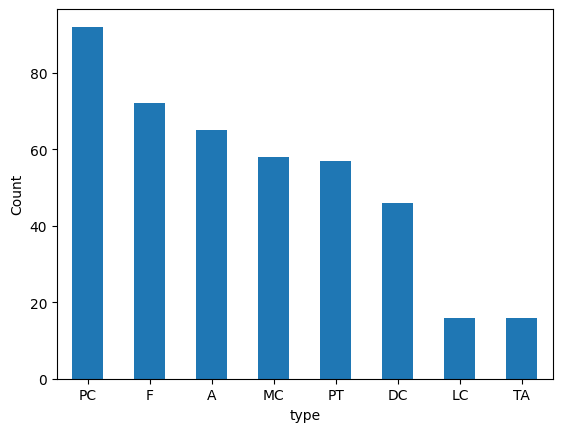

In [9]:
# df_B_type = df[df['class'] == 'B']
# df_B_type['type'].value_counts().plot(kind='bar', xlabel='type', ylabel='Count', rot=0)

# df_M_type = df[df['class']== 'M']
# df_M_type['type'].value_counts().plot(kind='bar', xlabel = 'type', ylabel='Count', rot=0)

df['type'].value_counts().plot(kind='bar', xlabel = 'type', ylabel='Count', rot=0)

* Now you can create a more advanced visualisation of the images like shown below by using `ImageGrid` object from the `matplotlib` library (https://matplotlib.org/3.1.3/gallery/axes_grid1/simple_axesgrid.html). Here we visualise the 4 first images of each class.

/tmp/ipykernel_452/132761684.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


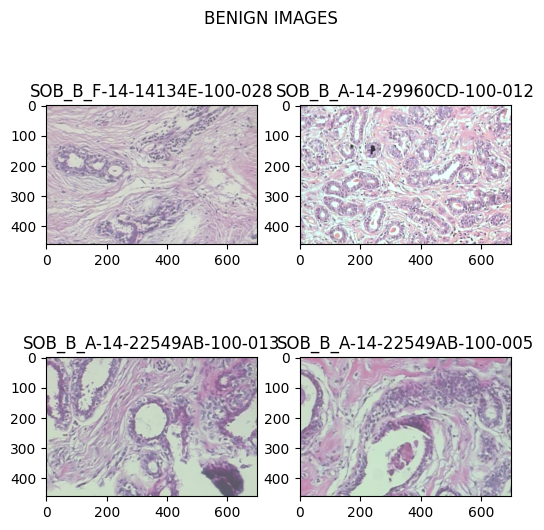

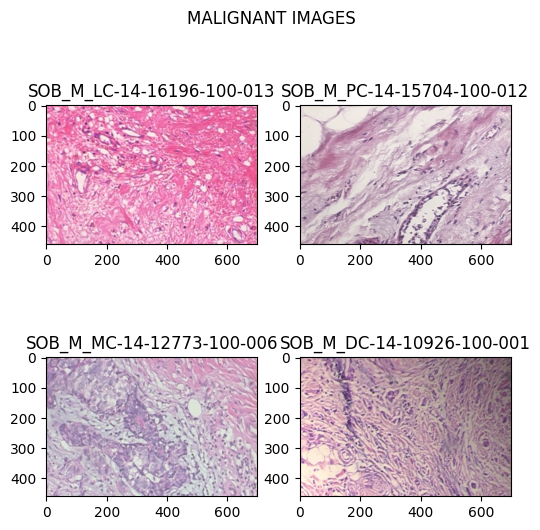

In [36]:
# plot 4 images for each class
b_img = df[df['class'] == 'B'].head(4)
m_img = df[df['class'] == 'M'].head(4)

for class_name, class_images in [['BENIGN', b_img], ['MALIGNANT', m_img]]:
    fig, axs = plt.subplots(2,2,figsize=(6, 6))
    fig.suptitle('{0} IMAGES'.format(class_name), fontsize=12)
    i = 0
    j = 0
    for idx, img in class_images.iterrows():
        ax = axs[i, j]
        ax.set_title(img['filename'][:-4])
        ax.imshow(io.imread('data-challenge/Train/' + img['filename']))
        j = j + 1 if j < 1 else 0
        i = i + 1 if j == 0 else i
    fig.show()

### Examples of features extraction (from image processing)

* To perform machine learning, you need to map each image to a vector or representation. 

* Feature extraction is necessary to extract information from the raw data, in order to enrich their description. Selecting the most meaningful features is a crucial step in the process of classification problems.

* The selected set of features should be a small set whose values efficiently discriminate among patterns of the different classes, but are similar for patterns within the same class.

* Here we will calculate 3 global features on each image. To do so, we can use functions from `OpenCV` and `mahotas` libraries: 

  * Hu moments: https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html
  * Haralick: https://mahotas.readthedocs.io/en/latest/features.html
  * Color histogram in HSV: https://docs.opencv.org/master/dd/d0d/tutorial_py_2d_histogram.html

In [11]:
# parameters for the features extraction
bins = 8

# functions to extract features from the images
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

*Concatenation of the features for each image in the list to extend the `DataFrame` defined earlier. Note that there are 7 values for the Hu moments, 13 for the Haralick features and 512 for the histogram. At the end, the `DataFrame` contains 532 values between 0 and 1 for the global features calculated.

In [12]:
# Compute the features
feat_haralick = []
feat_histogram = []
feat_hu = []

for i in images:
    img = cv2.imread('data-challenge/Train/' + i)  # Load image
    feat_hu.append(fd_hu_moments(img))  # Append Hu values
    feat_haralick.append(fd_haralick(img))  # Append Haralick values
    feat_histogram.append(fd_histogram(img))  # Append Histogram values

In [13]:
# Concatenate with the original data frame 
df_features = np.hstack([feat_haralick, feat_hu, feat_histogram])
df_features = pd.DataFrame(df_features)
df_features.shape

(422, 532)

### Training a Classifier

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df['type_id'], stratify=df['type_id'], test_size=0.2)
print(y_train.value_counts() / len(y_train))
print(y_test.value_counts() / len(y_test))

3    0.216617
1    0.169139
7    0.154303
5    0.136499
4    0.136499
2    0.109792
6    0.038576
8    0.038576
Name: type_id, dtype: float64
3    0.223529
1    0.176471
7    0.152941
5    0.141176
4    0.129412
2    0.105882
8    0.035294
6    0.035294
Name: type_id, dtype: float64


In [15]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state=1, max_depth=5, n_estimators=10, max_features=1)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

0.4823529411764706
              precision    recall  f1-score   support

           1       0.50      0.33      0.40        15
           2       0.33      0.33      0.33         9
           3       0.67      0.42      0.52        19
           4       0.25      0.18      0.21        11
           5       0.58      0.58      0.58        12
           6       0.40      0.67      0.50         3
           7       0.44      0.85      0.58        13
           8       0.75      1.00      0.86         3

    accuracy                           0.48        85
   macro avg       0.49      0.55      0.50        85
weighted avg       0.50      0.48      0.47        85

0.49742653003476434


**IMPORTANT** The proposed feature extraction schema is ONE way to proceed to map images to vectors. You are free to explore other ways. 

## Create a submission file for the test set

For evaluation, you'll have to submit a csv file with image id and the predicted class.

You'll be evaluated on the basis of the F1-Score. 
Hereafter is an example of the expected format for your sumbission. 

In [16]:
# Test images
images_test = os.listdir(path='data-challenge/Test/')

# Number of images
print("Number of images for the test set: ", len(images_test))

Number of images for the test set:  207


In [23]:
def parseTest_fn(filename):
    # <BIOPSY_PROCEDURE>_<ID>
    parsed = filename[:-4].split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'id', 'filename']

df_test = pd.DataFrame(list(map(parseTest_fn, images_test)), columns=columns)
print(df_test.head())
print(df_test.shape)

  procedure   id     filename
0       SOB  155  SOB_155.png
1       SOB  167  SOB_167.png
2       SOB  180  SOB_180.png
3       SOB   77   SOB_77.png
4       SOB  165  SOB_165.png
(207, 3)


In [18]:
# Compute the features
feat_haralick_test = []
feat_histogram_test = []
feat_hu_test = []

for i in images_test:
    img = cv2.imread('data-challenge/Test/' + i)  # Load image
    feat_hu_test.append(fd_hu_moments(img))  # Append Hu values
    feat_haralick_test.append(fd_haralick(img))  # Append Haralick values
    feat_histogram_test.append(fd_histogram(img))  # Append Histogram values

In [19]:
# Concatenate with the original data frame 
df_features_test = np.hstack([feat_haralick_test, feat_hu_test, feat_histogram_test])
df_features = pd.DataFrame(df_features_test)
df_features_test.shape

(207, 532)

In [50]:
y_pred_test = model_rf.predict(df_features_test)
df_pred = pd.concat([df_test['id'], pd.Series(y_pred_test, name='type_id')], axis=1)
display(df_pred['type_id'].value_counts())
df_pred.to_csv('my_pred.csv', index=False, header=False)

7    65
2    41
3    38
1    28
5    21
4    12
8     2
Name: type_id, dtype: int64

### Up to you now ! 

# Implemented Methods

## General Functions

In [77]:
def create_features(imgs, data_path='data-challenge/Train/'):
    # Compute the features
    feat_haralick = []
    feat_histogram = []
    feat_hu = []
    print(data_path)
    for i in imgs:
        img = cv2.imread(data_path + i)  # Load image
        feat_hu.append(fd_hu_moments(img))  # Append Hu values
        feat_haralick.append(fd_haralick(img))  # Append Haralick values
        feat_histogram.append(fd_histogram(img))  # Append Histogram values
    
    df_features = np.hstack([feat_haralick, feat_hu, feat_histogram])
    df_features = pd.DataFrame(df_features)
    print(df_features.shape)

    return df_features

def parse_fn(filename):
    # <BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>-<YEAR>-<SLIDE_ID>-<MAG>-<SEQ>
    parsed = filename[:-4].replace('-', '_').split('_')
    parsed.append(filename)
    return parsed

def create_split(images_train, images_test, train_path, test_path):
    columns = ['procedure', 'class', 'type', 'magnification', 'slide', 'mag', 'seq', 'filename']

    df = pd.DataFrame(list(map(parse_fn, images_train)), columns=columns)
    label_maps = {'F':'1', 'DC':'2', 'PC':'3', 'PT':'4', 'MC':'5', 'LC':'6', 'A':'7', 'TA':'8'}
    df['type_id'] = df['type'].apply(lambda x: label_maps[x])
    
    df_features = create_features(images_train, train_path)
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['type_id'], stratify=df['type_id'], test_size=0.2)

    columns = ['procedure', 'id', 'filename']
    info_test = pd.DataFrame(list(map(parseTest_fn, images_test)), columns=columns)
    df_features_test = create_features(info_test['filename'], test_path)

    return X_train, X_val, y_train, y_val, df_features_test, info_test

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(accuracy_score(y_val,y_pred))
    print(classification_report(y_val, y_pred))
    print(f1_score(y_val, y_pred, average='macro'))
    return y_pred

def create_submission(model, X_test, info_test):
    y_pred_test = model.predict(X_test)
    df_pred = pd.concat([info_test['id'], pd.Series(y_pred_test, name='type_id')], axis=1)

    display(df_pred['type_id'].value_counts())
    df_pred.to_csv('my_pred.csv', index=False, header=False)
    

## Data Preprocessing

In [78]:
images_train = os.listdir(path='data-challenge/Train/')
images_test = os.listdir(path='data-challenge/Test/')
train_path = 'data-challenge/Train/'
test_path = 'data-challenge/Test/'

X_train, X_val, y_train, y_val, df_features_test, info_test = create_split(images_train, images_test, train_path, test_path)

data-challenge/Train/
(422, 532)
data-challenge/Test/
(207, 532)


## Random Forest

In [101]:
model_rf = RandomForestClassifier(random_state=1, max_depth=7, n_estimators=2000, max_features="sqrt")
model_rf.fit(X_train, y_train)
evaluate_model(model_rf, X_val, y_val)

create_submission(model_rf, df_features_test, info_test)

0.8117647058823529
              precision    recall  f1-score   support

           1       0.64      0.93      0.76        15
           2       1.00      0.78      0.88         9
           3       0.76      1.00      0.86        19
           4       1.00      0.27      0.43        11
           5       1.00      0.75      0.86        12
           6       1.00      1.00      1.00         3
           7       0.85      0.85      0.85        13
           8       1.00      1.00      1.00         3

    accuracy                           0.81        85
   macro avg       0.91      0.82      0.83        85
weighted avg       0.86      0.81      0.80        85

0.8284076565326566


7    64
3    42
2    40
1    33
4    16
5    10
8     2
Name: type_id, dtype: int64

## Light GBM

In [102]:
import lightgbm as lgb

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'binary',
    'learning_rate': 0.1,
    'num_leaves': 4,
    'verbose': 1
}
model_lgbm = lgb
model_lgbm.fit()
evaluate_model(model_lgbm, X_val, y_val)

create_submission(model_lgbm, df_features_test, info_test)